# Analyze data

## Dependency

In [132]:
import os
import pprint
import collections
from datetime import timedelta

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from dotenv import load_dotenv

load_dotenv()
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("expand_frame_repr", False)

## Parameter

In [101]:
API_KEY = os.environ["API_KEY"]
API_URL = os.environ["API_URL"]
INSTRUMENT = "USD_JPY"
GRANULARITY = "D"
COUNT = "5000"
# SMAS = [200, 100, 50, 25, 15]
SMAS = [15, 25, 50, 100, 200]
N_SLOPE = 25
N_CANDLE = 3
N_PREDICT = 5
VALI_SIZE = 0.2
RANDOM_STATE = 0
CV = 5
CSV_01 = "./data.csv"

## Function

In [68]:
def make_headers():
    return {
        "Authorization": f"Bearer {API_KEY}",
        "Content-Type": "application/json"
    }


def get_candles(instrument, headers):
    payload = {
        "price": "M",
        "granularity": GRANULARITY,
        "count": COUNT,
        "alignmentTimezone": "UTC"
    }
    r = requests.get(
        url=f"{API_URL}/v3/instruments/{instrument}/candles",
        headers=headers,
        params=payload
    )
    # print("get_candles()")
    # print(f"Status code: {r.status_code}")
    # pprint.pprint(r.json()["candles"])

    candles = r.json()["candles"]


    return candles


def convert_candle_to_df(candles):
    data = []
    for candle in candles:
        d = dict()
        d["time"] = candle["time"]
        d["open"] = candle["mid"]["o"]
        d["high"] = candle["mid"]["h"]
        d["low"] = candle["mid"]["l"]
        d["close"] = candle["mid"]["c"]
        data.append(d)

    # pprint.pprint(data)

    df = pd.DataFrame(data)
    df = clean_df(df)

    print("convert_candle_to_df()")
    print(df.shape)
    print(df.dtypes)
    print(df.head())
    print(df.tail())
    print()

    return df


def clean_df(df):
    df_c = df.copy()
    df_c["time"] = pd.to_datetime(df_c["time"])
    for c in ["open", "high", "low", "close"]:
        df_c[c] = pd.to_numeric(df_c[c])
    return df_c


def engineer_features(df):
    df_c = df.copy()
    df_c["date"] = df_c["time"].dt.date
    df_c.set_index("date", inplace=True)

    for n in SMAS:
        # Compute simple moving average
        df_c[f"sma_{n}"] = df_c["close"].rolling(window=n).mean()
        # Compute slope of simple moving average
        df_c[f"slope_{N_SLOPE}_sma_{n}"] = compute_sma_slope(df_c[f"sma_{n}"].to_list(), N_SLOPE)
        # Compute position of current price relative to simple moving average
        df_c[f"price_position_to_sma_{n}"] = compute_price_position_to_sma(df_c[f"sma_{n}"].to_list(), df_c["close"].to_list())

    # Compute candle information
    upper_shadows = []
    bodys = []
    lower_shadows = []
    for i, row in df.iterrows():
        res = compute_candle_information(row["open"], row["high"], row["low"], row["close"])
        upper_shadows.append(res[0])
        bodys.append(res[1])
        lower_shadows.append(res[2])
    df_c["upper_shadow_0"] = upper_shadows
    df_c["body_0"] = bodys
    df_c["lower_shadow_0"] = lower_shadows
   
    for m in range(1, N_CANDLE):
        df_c[f"upper_shadow_{m}"] = df_c["upper_shadow_0"].shift(m)
        df_c[f"body_{m}"] = df_c["body_0"].shift(m)
        df_c[f"lower_shadow_{m}"] = df_c["lower_shadow_0"].shift(m)

    # CLean
    df_c.dropna(inplace=True)    
    df_c.drop(
        columns=["time", "open", "high", "low"],
        inplace=True
    )

    # Create Y
    y = df_c["close"].shift(-N_PREDICT)
    df_c.insert(0, "y", y)
    
    print("engineer_features()")
    print(df_c.shape)
    print(df_c.dtypes)
    print(df_c.head())
    print(df_c.tail())
    print()

    return df_c


def compute_sma_slope(sma, n):
    queue = collections.deque(maxlen=n)
    res = []
    
    for price in sma:
    
        queue.append(price)
    
        if len(queue) == n:
            x = [i for i in range(len(queue))]
            slope, intercept = np.polyfit(x, queue, 1)
            res.append(slope)
        else:
            res.append(None)

    return res


def compute_price_position_to_sma(smas, closes):
    res = []
    for i in range(len(smas)):

        if smas[i] is None:
            continue

        position = closes[i] / smas[i]
        res.append(position)

    return res


def compute_candle_information(open_, high, low, close):
    upper_shadow = high - max(open_, close)
    lower_shadow = min(open_, close) - low
    # body is positive if go up, and negative if go down
    body = close - open_
    return upper_shadow, body, lower_shadow

## Make headers

In [69]:
headers = make_headers()

## Get candles

In [70]:
candles = get_candles(INSTRUMENT, headers)

## Convert to dataframe

In [71]:
df = convert_candle_to_df(candles)

convert_candle_to_df()
(5000, 5)
time     datetime64[ns, UTC]
open                 float64
high                 float64
low                  float64
close                float64
dtype: object
                       time    open    high     low   close
0 2009-01-09 17:00:00+00:00  90.260  90.592  90.162  90.398
1 2009-01-11 17:00:00+00:00  90.348  90.399  88.884  88.934
2 2009-01-12 17:00:00+00:00  88.932  89.880  88.780  89.620
3 2009-01-13 17:00:00+00:00  89.622  89.961  88.614  89.302
4 2009-01-14 17:00:00+00:00  89.298  89.774  88.480  89.604
                          time     open     high      low    close
4995 2024-10-27 17:00:00+00:00  153.207  153.882  152.410  153.262
4996 2024-10-28 17:00:00+00:00  153.257  153.868  152.756  153.549
4997 2024-10-29 17:00:00+00:00  153.550  153.600  152.782  153.084
4998 2024-10-30 17:00:00+00:00  153.084  153.628  151.922  152.444
4999 2024-10-31 17:00:00+00:00  152.444  152.490  151.804  151.806



## Feature engineering

In [72]:
df = engineer_features(df)

engineer_features()
(4777, 26)
y                            float64
close                        float64
sma_15                       float64
slope_25_sma_15              float64
price_position_to_sma_15     float64
sma_25                       float64
slope_25_sma_25              float64
price_position_to_sma_25     float64
sma_50                       float64
slope_25_sma_50              float64
price_position_to_sma_50     float64
sma_100                      float64
slope_25_sma_100             float64
price_position_to_sma_100    float64
sma_200                      float64
slope_25_sma_200             float64
price_position_to_sma_200    float64
upper_shadow_0               float64
body_0                       float64
lower_shadow_0               float64
upper_shadow_1               float64
body_1                       float64
lower_shadow_1               float64
upper_shadow_2               float64
body_2                       float64
lower_shadow_2               float64
dtype: 

In [73]:
df.head(10)

,y,close,sma_15,slope_25_sma_15,price_position_to_sma_15,sma_25,slope_25_sma_25,price_position_to_sma_25,sma_50,slope_25_sma_50,price_position_to_sma_50,sma_100,slope_25_sma_100,price_position_to_sma_100,sma_200,slope_25_sma_200,price_position_to_sma_200,upper_shadow_0,body_0,lower_shadow_0,upper_shadow_1,body_1,lower_shadow_1,upper_shadow_2,body_2,lower_shadow_2
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-09-24,89.694,89.805,91.131067,-0.145054,0.985449,91.83004,-0.148277,0.977948,93.51376,-0.044563,0.960340,94.51105,-0.040368,0.950206,95.731630,0.010732,0.938091,0.394,-1.383,0.286,0.248,-0.192,0.834,0.154,0.220,0.682
2009-09-25,89.675,89.660,90.978867,-0.143756,0.985504,91.67408,-0.148771,0.978030,93.41422,-0.047550,0.959811,94.44763,-0.040437,0.949309,95.720470,0.009927,0.936686,0.138,-0.143,0.097,0.394,-1.383,0.286,0.248,-0.192,0.834
2009-09-27,89.803,89.426,90.818867,-0.142920,0.984663,91.50752,-0.148563,0.977253,93.30906,-0.051007,0.958385,94.37641,-0.040816,0.947546,95.710270,0.009006,0.934341,0.087,-0.229,1.206,0.138,-0.143,0.097,0.394,-1.383,0.286
2009-09-28,89.652,90.200,90.800067,-0.141249,0.993391,91.40204,-0.147522,0.986849,93.20806,-0.055018,0.967727,94.29619,-0.041698,0.956560,95.708015,0.008097,0.942450,0.164,0.778,0.048,0.087,-0.229,1.206,0.138,-0.143,0.097
2009-09-29,88.792,89.680,90.730533,-0.138759,0.988421,91.26572,-0.145892,0.982625,93.09334,-0.059449,0.963334,94.20639,-0.043100,0.951952,95.703075,0.007172,0.937065,0.201,-0.522,0.322,0.164,0.778,0.048,0.087,-0.229,1.206
2009-09-30,88.808,89.694,90.652667,-0.136304,0.989425,91.16820,-0.143469,0.983830,92.98862,-0.064286,0.964570,94.11939,-0.045037,0.952981,95.698735,0.006220,0.937254,0.470,0.010,0.266,0.201,-0.522,0.322,0.164,0.778,0.048
2009-10-01,88.322,89.675,90.570800,-0.133361,0.990109,91.05344,-0.140514,0.984861,92.87082,-0.069016,0.965589,94.04038,-0.047273,0.953580,95.687965,0.005202,0.937161,0.228,-0.021,1.063,0.470,0.010,0.266,0.201,-0.522,0.322
2009-10-02,89.760,89.803,90.502200,-0.129820,0.992274,90.92732,-0.137769,0.987635,92.71564,-0.073966,0.968585,93.95631,-0.049664,0.955795,95.677690,0.004128,0.938599,0.008,0.131,0.200,0.228,-0.021,1.063,0.470,0.010,0.266
2009-10-04,89.743,89.652,90.394867,-0.125450,0.991782,90.79312,-0.135335,0.987432,92.55738,-0.078892,0.968610,93.87423,-0.052108,0.955022,95.666950,0.002993,0.937126,0.182,-0.148,0.404,0.008,0.131,0.200,0.228,-0.021,1.063


In [74]:
df.tail(10)

,y,close,sma_15,slope_25_sma_15,price_position_to_sma_15,sma_25,slope_25_sma_25,price_position_to_sma_25,sma_50,slope_25_sma_50,price_position_to_sma_50,sma_100,slope_25_sma_100,price_position_to_sma_100,sma_200,slope_25_sma_200,price_position_to_sma_200,upper_shadow_0,body_0,lower_shadow_0,upper_shadow_1,body_1,lower_shadow_1,upper_shadow_2,body_2,lower_shadow_2
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-21,153.262,151.062,149.401800,0.328223,1.011112,147.48212,0.191827,1.024273,145.44890,0.016388,1.038592,149.28820,-0.095929,1.011882,151.810355,-0.010967,0.995070,0.137,0.545,0.022,0.043,1.001,0.430,0.120,0.113,0.006
2024-10-22,153.549,152.858,149.678867,0.336852,1.021240,147.85788,0.211149,1.033817,145.61680,0.027797,1.049728,149.20827,-0.094475,1.024461,151.822385,-0.009593,1.006821,0.332,1.796,0.162,0.137,0.545,0.022,0.043,1.001,0.430
2024-10-23,153.084,151.693,149.924800,0.343608,1.011794,148.14432,0.229824,1.023954,145.76788,0.038483,1.040648,149.11647,-0.093216,1.017279,151.830110,-0.008159,0.999097,0.054,-1.165,0.031,0.332,1.796,0.162,0.137,0.545,0.022
2024-10-24,152.444,152.197,150.194467,0.348473,1.013333,148.43788,0.247599,1.025325,145.91698,0.048371,1.043038,149.02324,-0.092171,1.021297,151.845205,-0.006567,1.002317,0.033,0.503,0.244,0.054,-1.165,0.031,0.332,1.796,0.162
2024-10-25,151.806,152.304,150.398600,0.349451,1.012669,148.82956,0.264115,1.023345,146.06294,0.057255,1.042729,148.93052,-0.091470,1.022651,151.866255,-0.004902,1.002882,0.078,0.108,0.100,0.033,0.503,0.244,0.054,-1.165,0.031
2024-10-27,NaN,153.262,150.688067,0.347320,1.017081,149.27144,0.278848,1.026734,146.20366,0.064926,1.048277,148.84778,-0.090957,1.029656,151.896675,-0.003191,1.008989,0.620,0.055,0.797,0.078,0.108,0.100,0.033,0.503,0.244
2024-10-28,NaN,153.549,150.990933,0.342214,1.016942,149.68884,0.291479,1.025788,146.35058,0.072002,1.049186,148.77194,-0.090644,1.032110,151.929035,-0.001428,1.010663,0.319,0.292,0.501,0.620,0.055,0.797,0.078,0.108,0.100
2024-10-29,NaN,153.084,151.254667,0.335054,1.012094,150.06672,0.301189,1.020106,146.47588,0.078279,1.045114,148.69392,-0.090508,1.029524,151.960090,0.000357,1.007396,0.050,-0.466,0.302,0.319,0.292,0.501,0.620,0.055,0.797
2024-10-30,NaN,152.444,151.422000,0.326487,1.006749,150.32312,0.307848,1.014109,146.60940,0.084643,1.039797,148.61033,-0.090482,1.025797,151.983795,0.002166,1.003028,0.544,-0.640,0.522,0.050,-0.466,0.302,0.319,0.292,0.501


## Train validation test split

In [117]:
df_data = df.loc[~df["y"].isna()]
df_no_data = df.loc[df["y"].isna()]

print("Data after feature engineering: ", df.shape)
print("Data for model: ", df_data.shape)
print("Data not for model", df_no_data.shape)

n_test = 5
df_test = df_data.iloc[-n_test:]
df_model = df_data.iloc[:-n_test]

print(f"Model: {df_model.shape}")
print(f"Test: {df_test.shape}")

Data after feature engineering:  (4777, 26)
Data for model:  (4772, 26)
Data not for model (5, 26)
Model: (4767, 26)
Test: (5, 26)


In [105]:
df_test

,y,close,sma_15,slope_25_sma_15,price_position_to_sma_15,sma_25,slope_25_sma_25,price_position_to_sma_25,sma_50,slope_25_sma_50,price_position_to_sma_50,sma_100,slope_25_sma_100,price_position_to_sma_100,sma_200,slope_25_sma_200,price_position_to_sma_200,upper_shadow_0,body_0,lower_shadow_0,upper_shadow_1,body_1,lower_shadow_1,upper_shadow_2,body_2,lower_shadow_2
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-21,153.262,151.062,149.401800,0.328223,1.011112,147.48212,0.191827,1.024273,145.44890,0.016388,1.038592,149.28820,-0.095929,1.011882,151.810355,-0.010967,0.995070,0.137,0.545,0.022,0.043,1.001,0.430,0.120,0.113,0.006
2024-10-22,153.549,152.858,149.678867,0.336852,1.021240,147.85788,0.211149,1.033817,145.61680,0.027797,1.049728,149.20827,-0.094475,1.024461,151.822385,-0.009593,1.006821,0.332,1.796,0.162,0.137,0.545,0.022,0.043,1.001,0.430
2024-10-23,153.084,151.693,149.924800,0.343608,1.011794,148.14432,0.229824,1.023954,145.76788,0.038483,1.040648,149.11647,-0.093216,1.017279,151.830110,-0.008159,0.999097,0.054,-1.165,0.031,0.332,1.796,0.162,0.137,0.545,0.022
2024-10-24,152.444,152.197,150.194467,0.348473,1.013333,148.43788,0.247599,1.025325,145.91698,0.048371,1.043038,149.02324,-0.092171,1.021297,151.845205,-0.006567,1.002317,0.033,0.503,0.244,0.054,-1.165,0.031,0.332,1.796,0.162
2024-10-25,151.806,152.304,150.398600,0.349451,1.012669,148.82956,0.264115,1.023345,146.06294,0.057255,1.042729,148.93052,-0.091470,1.022651,151.866255,-0.004902,1.002882,0.078,0.108,0.100,0.033,0.503,0.244,0.054,-1.165,0.031


## Develop model

In [108]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor()

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=CV, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
y_train = df_model.pop("y")
close_train = df_model.pop("close")
X_train = df_model
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.7}
Best score:  -85.7647571669641


## Evaluate model

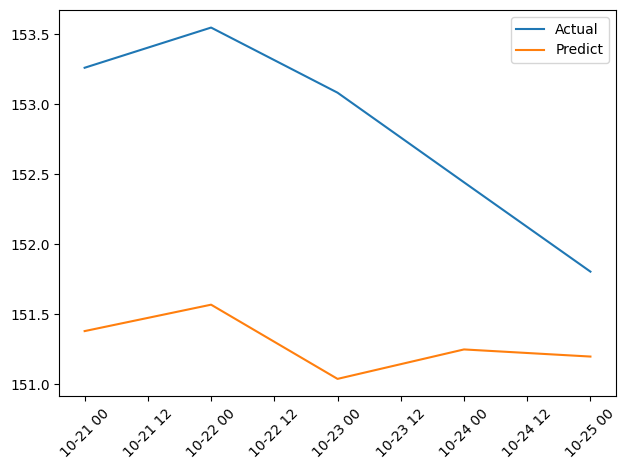

In [124]:
model = grid_search.best_estimator_

df_c = df_test.copy()
y_test = df_c.pop("y")
close_test = df_c.pop("close")
X_test = df_c

y_test_pred = model.predict(X_test)
df_eval = df_test.copy()
df_eval.insert(0, "y_pred", y_test_pred)

plt.plot(df_eval["y"], label="Actual")
plt.plot(df_eval["y_pred"], label="Predict")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Prediction

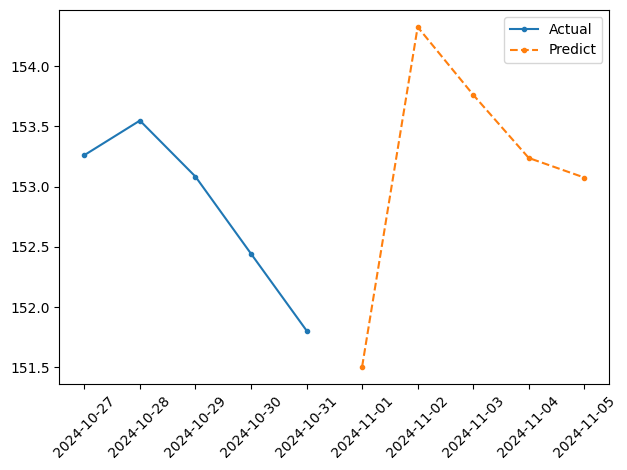

In [138]:
df_c = df_no_data.copy()

df_c.pop("y")
close_no_data = df_c.pop("close")
X_no_data = df_c

# Create prediction data
y_test_pred = model.predict(X_no_data)
indices = []
for i in range(N_PREDICT):
    t = close_no_data.index[-1] + timedelta(days=i + 1)
    indices.append(t)
predicts = pd.Series(data=y_test_pred, index=indices)

plt.plot(close_no_data, marker=".", label="Actual")
plt.plot(predicts, marker=".", linestyle="--", label="Predict")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()